In [1]:
! mkdir ~/.kaggle

In [2]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
License(s): CC0-1.0
 97% 319M/330M [00:05<00:00, 98.8MB/s]
100% 330M/330M [00:05<00:00, 63.6MB/s]


In [5]:
! unzip face-mask-12k-images-dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/T

In [55]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import numpy as np

In [175]:
base_dir = '/content/Face Mask Dataset'

train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [121]:
from keras.applications import ResNet50
from keras.models import Sequential, load_model
from keras.layers import Dense

base_model = ResNet50(weights='imagenet', pooling='avg', include_top=False)

base_model.trainable = False

model = Sequential([
    base_model,
    Dense(2, activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [122]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [123]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch = 10,
        epochs = 2,
        validation_data = val_generator,
        validation_steps = 10
)

Epoch 1/2
10/10 [==============================] - 150s 16s/step - loss: 0.1325 - accuracy: 0.9625 - val_loss: 0.0506 - val_accuracy: 0.9781
Epoch 2/2
10/10 [==============================] - 141s 15s/step - loss: 0.0209 - accuracy: 0.9937 - val_loss: 0.0218 - val_accuracy: 0.9875


In [183]:
model.save('/content/drive/MyDrive/28/best')

In [185]:
model = load_model('/content/drive/MyDrive/28/best')

In [222]:
images, label = next(test_generator)
pred = model.predict(images)
pred_class = np.argmax(pred, axis=1)

1/1 [==============================] - 8s 8s/step


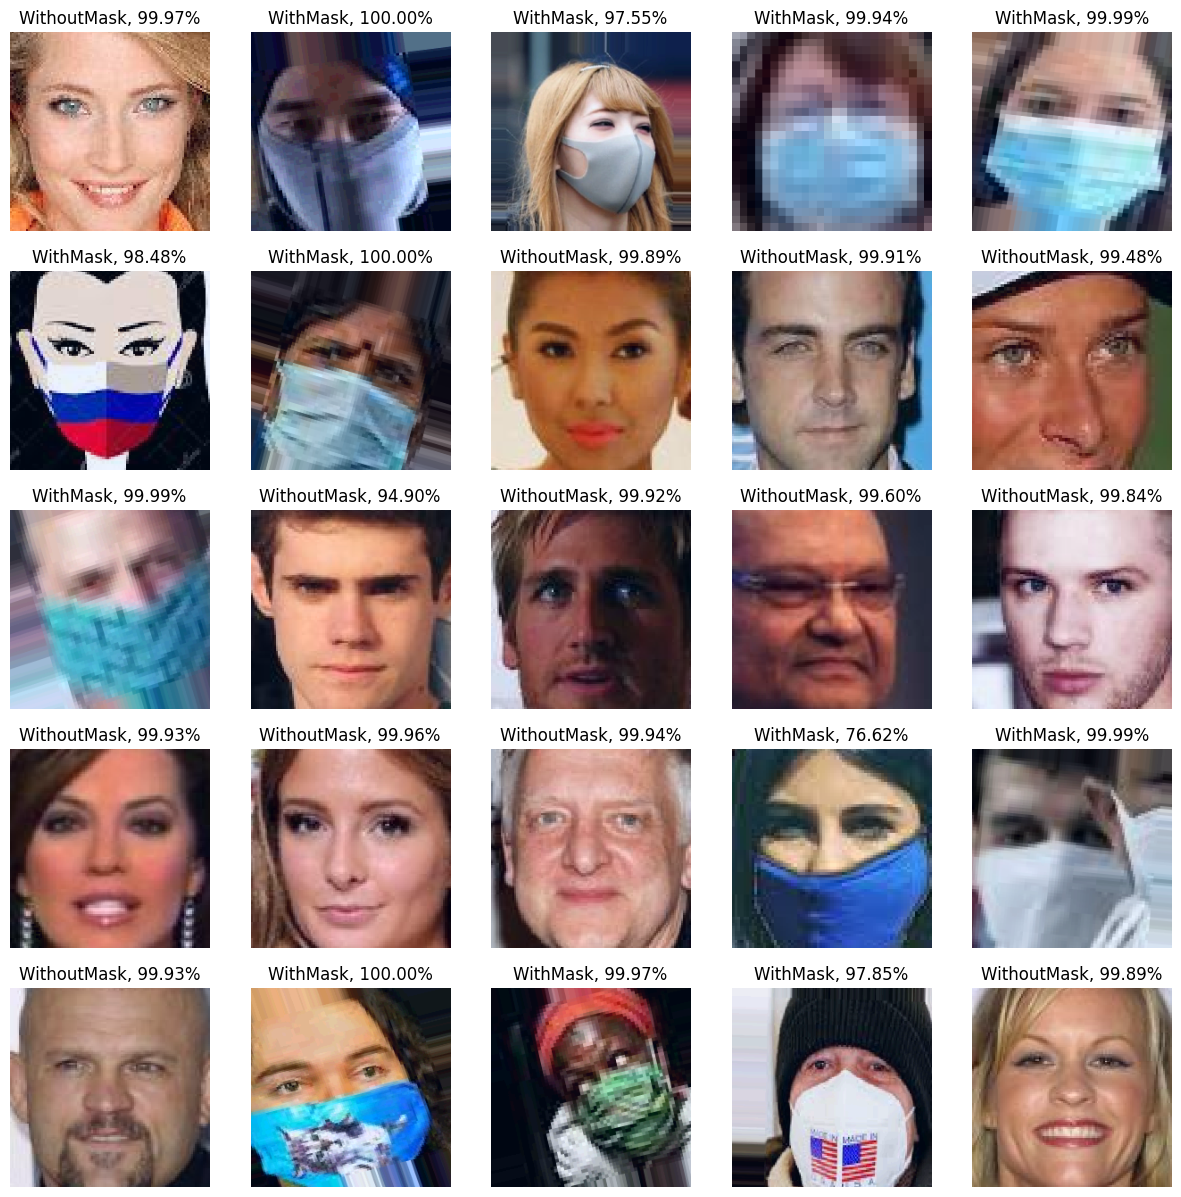

In [228]:
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0, 25):
    predicted_class = "WithoutMask" if pred_class[i] else "WithMask"
    imgRGB = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)/255
    ax[i//5, i%5].imshow((imgRGB - np.min(imgRGB))/(np.max(imgRGB) - np.min(imgRGB)))
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(f"{predicted_class}, {np.max(pred[i]) * 100:.2f}%")

plt.show()

In [176]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Точность на тестовых данных: {test_accuracy * 100:.2f}%')

31/31 [==============================] - 188s 6s/step - loss: 0.0208 - accuracy: 0.9929
Точность на тестовых данных: 99.29%
